In [1]:
### Import packages ###
#Basics
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
import string

#Visualization
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *

from IPython.display import display, HTML
import pandas_profiling


#NLP
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer

import contractions
from wordsegment import load, segment
#https://pypi.org/project/wordsegment/
#https://github.com/cbaziotis/ekphrasis
#word segmentation, spell correction????

from spellchecker import SpellChecker
from utils import clean

#Emojis & emoticons
import emojis_extra
#https://pypi.org/project/emojis/

import emot
#https://pypi.org/project/emot/

Using TensorFlow backend.


In [2]:
### Import data ###
train = pd.read_csv('./data/SemEval/olid-training-v1.0.tsv', sep='\t')
test_a = pd.read_csv('./data/SemEval/testset-levela.tsv', sep='\t')
test_b = pd.read_csv('./data/SemEval/testset-levelb.tsv', sep='\t')
test_c = pd.read_csv('./data/SemEval/testset-levelc.tsv', sep='\t')

train.head(1)
labels_a = pd.read_csv('./data/SemEval/labels-levela.csv', header=None)
labels_a.columns = ['id', 'subtask_a']
test_a = pd.merge(test_a, labels_a, on='id')

labels_b = pd.read_csv('./data/SemEval/labels-levelb.csv', header=None)
labels_b.columns = ['id', 'subtask_b']
test_b = pd.merge(test_b, labels_b, on='id')

labels_c = pd.read_csv('./data/SemEval/labels-levelc.csv', header=None)
labels_c.columns = ['id', 'subtask_c']
test_c = pd.merge(test_c, labels_c, on='id')

In [5]:
pandas_profiling.ProfileReport(train)

Number of variables,5
Number of observations,13240
Total Missing (%),27.5%
Total size in memory,517.3 KiB
Average record size in memory,40.0 B
Numeric,1
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
display(train.tail(3))
display(test_a.head(3))
display(test_b.head(3))
display(test_c.head(3))

,id,tweet,subtask_a,subtask_b,subtask_c
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN
13239,46552,#Spanishrevenge vs. #justice #HumanRights and ...,NOT,NaN,NaN


,id,tweet,subtask_a
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT


,id,tweet,subtask_b
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,TIN
1,60133,#NoPasaran: Unity demo to oppose the far-right...,TIN
2,83681,. . . What the fuck did he do this time?,TIN


,id,tweet,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND


### Examples

In [7]:
#NOT
display(pd.DataFrame(train[train.subtask_a=="NOT"].loc[:,'tweet'].sample(n=3)))
print("NOT")

#OFF & TIN & GRP
display(pd.DataFrame(train.loc[(train["subtask_a"]=="OFF")&(train["subtask_b"]=="TIN")&(train["subtask_c"]=="GRP"),"tweet"].sample(n=3)))
print("OFF & TIN & GRP")

#OFF & TIN & IND
display(pd.DataFrame(train.loc[(train["subtask_a"]=="OFF")&(train["subtask_b"]=="TIN")&(train["subtask_c"]=="IND"),"tweet"].sample(n=3)))
print("OFF & TIN & IND")

#OFF & TIN & OTH
display(pd.DataFrame(train.loc[(train["subtask_a"]=="OFF")&(train["subtask_b"]=="TIN")&(train["subtask_c"]=="OTH"),"tweet"].sample(n=3)))
print("OFF & TIN & OTH")

#OFF & UNT
display(pd.DataFrame(train.loc[(train["subtask_a"]=="OFF")&(train["subtask_b"]=="UNT"),"tweet"].sample(n=3)))
print("OFF & UNT")

,tweet
11719,@USER @USER @USER The bad &amp; the good are b...
3319,@USER @USER Yep..says the same thing about eve...
4067,@USER Gun control is not about guns. Gun contr...


NOT


,tweet
7246,@USER This is why women lose their credibility...
8640,#TheresaMay #MonsterMay #Conservatives must an...
5563,@USER @USER @USER Lol only ones I see attackin...


OFF & TIN & GRP


,tweet
11813,@USER @USER Probably have their violent libera...
2431,@USER You are still on that Trump train to no...
919,@USER Believe the woman. What person would vo...


OFF & TIN & IND


,tweet
2020,@USER @USER So is Fox News now campaigning for...
5043,@USER @USER @USER @USER Now Comes The Pain.......
10960,@USER You are being unkind to the pin!!!


OFF & TIN & OTH


,tweet
9639,@USER @USER 'Unintentionally' u fukin pedo.
10190,@USER @USER Still no excuse... Where TF are he...
13217,@USER “My head is a fuckin egg”


OFF & UNT


In [8]:
print("Shape training: {}".format(train.shape))
print("Shape test A: {}".format(test_a.shape))
print("Shape test B: {}".format(test_b.shape))
print("Shape test C: {}".format(test_c.shape))

Shape training: (13240, 5)
Shape test A: (860, 3)
Shape test B: (240, 3)
Shape test C: (213, 3)


### Tokens

In [9]:
tokenizer_train = Tokenizer(lower=True)
tokenizer_train.fit_on_texts(train['tweet'])
vocab_train = len(tokenizer_train.word_index) + 1
print("Vocab size train:", vocab_train)

tokenizer_test = Tokenizer(lower=True)
tokenizer_test.fit_on_texts(test_a['tweet'])
vocab_test = len(tokenizer_test.word_index) + 1
print("Vocab size train:", vocab_test)

set_train = set(list(tokenizer_train.word_index.keys()))
set_test = set(list(tokenizer_test.word_index.keys()))

set_train-set_test

Vocab size train: 21244
Vocab size train: 5480


{'founders',
 'kangaroo',
 'civically',
 'babesfortrump',
 'experiments',
 'salesmen',
 'myths',
 'faced',
 '£1bn',
 'inning',
 'blessings',
 'brutally',
 'h1ndu',
 'generate',
 'aide',
 'condom',
 'northwestern',
 'i’d',
 'lined',
 'zagami',
 'zeland',
 'sea',
 'obsessed”',
 'determines',
 "community's",
 '“eddandflow”',
 'commons',
 'idiocy',
 'smh',
 'generationally',
 'tyr',
 'yecs',
 'subpoena',
 'flake',
 'luminous',
 'skyped',
 '34',
 '450',
 'too🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸❤️🇺🇸🇺🇸❤️ps',
 'boypussy',
 'surveillance',
 'spam',
 '🤦🏾\u200d♂️',
 'outlaws',
 'chaste',
 'tracksuit',
 'displaced',
 'sm',
 'handiwork',
 'colombian',
 'nocaliforniademocrats',
 'denounce',
 'uterus',
 'biddy',
 'overturn',
 'calculative',
 'juncture',
 'wacked',
 '“sanctuary',
 'failures',
 'doing‼️',
 'client',
 'ownership🤣🤣🤣🤣🤣🤣',
 '🤔😐',
 'koolaid',
 'domme',
 'finalsay',
 'ipo',
 'inch',
 'richard',
 'improved',
 'wandering',
 'theresistance',
 '🇺🇸🙏💕',
 'scheduling',
 'upppp',
 'slobs',
 'thirty',
 'pubs',
 'pharmacist',


In [11]:
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

list_train = []
for tweet in train['tweet']:
    for token in tknzr.tokenize(tweet):
        list_train.append(token)
              
list_test = []
for tweet in test_a['tweet']:
    for token in tknzr.tokenize(tweet):
        list_test.append(token)
        
print("Vocab size:", len(set(list_train)))
print("Vocab size:", len(set(list_test)))

set(list_train)-set(list_test)

Vocab size: 20944
Vocab size: 5726


{'founders',
 'civically',
 'kangaroo',
 'experiments',
 'salesmen',
 '#bobpackwood',
 'faced',
 'myths',
 '#usefulidiot',
 '#goodtrumpsevil',
 'inning',
 'brutally',
 'blessings',
 'h1ndu',
 'generate',
 '#matta4congress',
 'aide',
 'condom',
 'northwestern',
 'lined',
 'zagami',
 'zeland',
 'sea',
 'determines',
 "community's",
 'commons',
 'idiocy',
 'smh',
 'generationally',
 'tyr',
 'yecs',
 'subpoena',
 'flake',
 'luminous',
 'skyped',
 '34',
 '450',
 'boypussy',
 'surveillance',
 'spam',
 'tracksuit',
 'n-word',
 'outlaws',
 'chaste',
 'wsj',
 'bullied',
 'monster',
 '#askalivelshi',
 '#houseoflords',
 'displaced',
 'sm',
 'handiwork',
 'colombian',
 'denounce',
 'uterus',
 'biddy',
 'overturn',
 'calculative',
 'juncture',
 '#notplastic',
 'wacked',
 'failures',
 'client',
 'koolaid',
 'domme',
 'ipo',
 'inch',
 'richard',
 'improved',
 'wandering',
 'scheduling',
 'slobs',
 'thirty',
 'pubs',
 'nickelodeon',
 'pharmacist',
 'low-emission',
 '#corbyn',
 'honked',
 'overall',
 "

In [12]:
occ_train = Counter(list_train)
occ_test = Counter(list_test)

occ_train.most_common()[-100:-1]
occ_train.most_common(100)

[('.', 14431),
 ('the', 9067),
 ('is', 6554),
 ('to', 6317),
 ('a', 5412),
 ('you', 5290),
 ('and', 5169),
 ('!', 4814),
 ('of', 3834),
 ('are', 3601),
 ('i', 3423),
 ('he', 2976),
 ('?', 2949),
 ('that', 2829),
 ('in', 2706),
 ('’', 2574),
 ('for', 2492),
 ('she', 2476),
 ('"', 2399),
 ('it', 2304),
 ('url', 2059),
 ('this', 1853),
 ('on', 1701),
 ('...', 1664),
 ('not', 1661),
 ('they', 1555),
 ('with', 1484),
 ('have', 1467),
 ('be', 1441),
 ('liberals', 1380),
 ('gun', 1368),
 ('so', 1274),
 ('all', 1249),
 (',', 1235),
 ('control', 1226),
 ('your', 1174),
 ('what', 1145),
 ('like', 1111),
 ('antifa', 1098),
 ('but', 1086),
 ('we', 1078),
 ('as', 1069),
 ('s', 1066),
 ('just', 1016),
 ('about', 1014),
 ('her', 1014),
 ('was', 984),
 ('t', 980),
 ('if', 973),
 ('will', 958),
 ('do', 946),
 ('who', 930),
 ('people', 911),
 ('conservatives', 871),
 ('no', 869),
 ('#maga', 823),
 ('his', 800),
 ('at', 775),
 ('my', 757),
 ('how', 756),
 ('from', 754),
 ('by', 753),
 ('or', 752),
 ('-',

In [13]:
occ_test.most_common(10)
occ_test.most_common()[-100:-1]

[('net', 1),
 ('designed', 1),
 ('close-up', 1),
 ('excessive', 1),
 ('outlook', 1),
 ('purple', 1),
 ('highest', 1),
 ('#ncwx', 1),
 ('#nrv', 1),
 ('#rke', 1),
 ('#feckless', 1),
 ('waste', 1),
 ('expending', 1),
 ('mentally', 1),
 ('unstable', 1),
 ('cowards', 1),
 ('#emmys2018', 1),
 ('sanda', 1),
 ('ho', 1),
 ('asia', 1),
 ('description', 1),
 ('sweetest', 1),
 ("thursday's", 1),
 ('nursing', 1),
 ('10:15', 1),
 ('afterwards', 1),
 ('tests', 1),
 ('lunch', 1),
 ('11:50', 1),
 ('strange', 1),
 ('unusual', 1),
 ("i'am", 1),
 ('sleepy', 1),
 ('bot', 1),
 ('cuddles', 1),
 ('browning', 1),
 ('fcs', 1),
 ('coverage', 1),
 ('videos', 1),
 ('#textureontherunway', 1),
 ('nyc', 1),
 ('emmy', 1),
 ('winner', 1),
 ('fierce', 1),
 ('#ctriders', 1),
 ('friday', 1),
 ('enjoy', 1),
 ('#readanewbookmonth', 1),
 ('patio', 1),
 ('cup', 1),
 ('month', 1),
 ('butch', 1),
 ('receives', 1),
 ('riled', 1),
 ('theme', 1),
 ('repeat', 1),
 ('rangers', 1),
 ('replacement', 1),
 ('fortifying', 1),
 ('longer',

### Emojis and emoticons

In [14]:
def get_emojis_emoticons(data):
    '''
    Returns all_emojis, id_emojis, all_emoticons, id_emoticons
    
    :param data: Complete dataset
    '''
    
    all_emojis = []
    id_emojis = []

    all_emoticons = []
    id_emoticons = []
    
    all_data = ' '.join(list(data['tweet']))
    
    for tweet_id, tweet_text in enumerate(data['tweet']):

        #Package: emojis
        emo = emojis_extra.get_all(tweet_text)

        if len(list(emo))>=1:
            for emoji in list(emo):
                all_emojis.append(emoji)
                id_emojis.append(tweet_id)

        #Package: emot    
        try:
            emoticons = emot.emoticons(tweet_text)['value']

            if len(list(emoticons))>=1:

                for emoticon in list(emoticons):
                    all_emoticons.append(emoticon)
                    id_emoticons.append(tweet_id)
        except:
            pass

    print("Count number of tweets with emojis: {} ({}%)".format(len(Counter(id_emojis).keys()), round(100*len(Counter(id_emojis).keys())/len(data), 2)))

    print("Count emojis: ", emojis_extra.count(all_data))
    print("Count unique emojis: ", emojis_extra.count(all_data, unique=True))
    
    print("Count number of tweets with emoticons: {} ({}%)".format(len(Counter(id_emoticons).keys()), round(100*len(Counter(id_emoticons).keys())/len(data), 3)))

    print("Count emoticons: ", len(all_emoticons))
    print("Count unique emoticons: ", len(Counter(all_emoticons).keys()))
    
    print(set(id_emojis).intersection(set(id_emoticons)))

    occ_emojis = Counter(all_emojis)
    print(occ_emojis.most_common())

    occ_emoticons = Counter(all_emoticons)
    print(occ_emoticons.most_common())
    
    return occ_emojis, occ_emoticons, all_emojis, id_emojis, all_emoticons, id_emoticons

In [15]:
all_ooc_emojis, all_occ_emoticons, all_emojis, id_emojis, all_emoticons, id_emoticons = get_emojis_emoticons(train)

Count number of tweets with emojis: 1434 (10.83%)
Count emojis:  3447
Count unique emojis:  307
Count number of tweets with emoticons: 80 (0.604%)
Count emoticons:  85
Count unique emoticons:  18
{11988, 9902, 806, 11071}
[('😂', 546), ('🇺🇸', 378), ('🤣', 213), ('❤️', 135), ('😭', 102), ('👍', 89), ('😍', 83), ('🤔', 79), ('👏', 71), ('🙏', 68), ('🙄', 54), ('😘', 49), ('😡', 47), ('🔥', 40), ('😁', 39), ('💕', 37), ('😊', 37), ('💜', 36), ('👇', 34), ('😆', 32), ('😀', 31), ('😉', 30), ('💀', 26), ('😎', 25), ('💯', 25), ('♥️', 24), ('👊', 23), ('😠', 23), ('💥', 20), ('🤢', 20), ('👌', 19), ('😢', 19), ('😅', 19), ('🌹', 19), ('💙', 19), ('😩', 17), ('💖', 17), ('💪', 16), ('🛑', 15), ('😒', 15), ('💩', 15), ('👀', 14), ('‼️', 14), ('💞', 14), ('😜', 14), ('🤗', 13), ('🖕', 13), ('😱', 12), ('🤡', 12), ('🗽', 11), ('🇬🇧', 11), ('😳', 11), ('🌪', 11), ('👉', 11), ('💛', 10), ('🐇', 10), ('👎', 10), ('😋', 10), ('🙂', 10), ('💃', 10), ('🤷\u200d♂', 9), ('🙌', 9), ('😏', 9), ('✅', 9), ('🇱🇷', 9), ('😄', 8), ('🤥', 8), ('👋', 8), ('💰', 8), ('👆', 8),

In [16]:
for emoji, count in all_ooc_emojis.most_common(10):
    print(emoji, "&", count, "&", emojis_extra.decode(emoji), "\\\\")

😂 & 546 & :joy: \\
🇺🇸 & 378 & :us: \\
🤣 & 213 & :rofl: \\
❤️ & 135 & :heart: \\
😭 & 102 & :sob: \\
👍 & 89 & :thumbsup: \\
😍 & 83 & :heart_eyes: \\
🤔 & 79 & :thinking: \\
👏 & 71 & :clap: \\
🙏 & 68 & :pray: \\


In [20]:
for emoji, count in all_ooc_emojis.most_common(10):
    print(emojis_extra.decode(emoji), "&", count, "\\\\")

:joy: & 546 \\
:us: & 378 \\
:rofl: & 213 \\
:heart: & 135 \\
:sob: & 102 \\
:thumbsup: & 89 \\
:heart_eyes: & 83 \\
:thinking: & 79 \\
:clap: & 71 \\
:pray: & 68 \\


In [21]:
print(max(Counter(id_emojis).values()))
print(min(Counter(id_emojis).values()))
print(sum(Counter(id_emojis).values())/len(Counter(id_emojis).keys()))

31
1
2.403765690376569


In [22]:
Counter(id_emojis).most_common(10)

[(11071, 31),
 (925, 23),
 (6596, 20),
 (9468, 19),
 (6791, 17),
 (7424, 17),
 (11273, 17),
 (2239, 16),
 (1329, 15),
 (6765, 15)]

In [23]:
train['tweet'][11071]

'@USER @USER #MAGA #KAG #TRUMP2020 #TRUMP=HERO #TRUMP=LEADER #WELUVTRUMP 🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸 URL'

In [24]:
print("\n Emojis \n ------")
print(train.iloc[id_emojis]['subtask_a'].value_counts(normalize=True))
print(train.iloc[id_emojis]['subtask_a'].value_counts())

print("\n Emoticons \n ---------")
print(train.iloc[id_emoticons]['subtask_a'].value_counts(normalize=True))
print(train.iloc[id_emoticons]['subtask_a'].value_counts())


 Emojis 
 ------
NOT    0.752248
OFF    0.247752
Name: subtask_a, dtype: float64
NOT    2593
OFF     854
Name: subtask_a, dtype: int64

 Emoticons 
 ---------
NOT    0.752941
OFF    0.247059
Name: subtask_a, dtype: float64
NOT    64
OFF    21
Name: subtask_a, dtype: int64


In [ ]:
all_ooc_emojis, all_occ_emoticons, all_emojis, id_emojis, all_emoticons, id_emoticons = get_emojis_emoticons(train)

In [26]:
all_ooc_emojis_test, all_occ_emoticons_test, all_emojis_test, id_emojis_test, all_emoticons_test, id_emoticons_test = get_emojis_emoticons(test_a)


Count number of tweets with emojis: 111 (12.91%)
Count emojis:  260
Count unique emojis:  112
Count number of tweets with emoticons: 11 (1.279%)
Count emoticons:  11
Count unique emoticons:  6
set()
[('😂', 21), ('🇺🇸', 17), ('❤️', 16), ('👏', 15), ('💜', 13), ('💚', 6), ('🔥', 6), ('🐅', 6), ('💛', 5), ('👍', 5), ('😭', 5), ('🖕', 5), ('👌', 4), ('🔗', 4), ('🤔', 4), ('👇', 4), ('🤵', 4), ('😡', 3), ('😢', 3), ('🤣', 3), ('🙌', 3), ('‼️', 3), ('🌻', 3), ('💕', 2), ('🔷', 2), ('🔹', 2), ('🇬🇧', 2), ('👼', 2), ('🌟', 2), ('♥️', 2), ('😍', 2), ('😑', 2), ('🙃', 2), ('💙', 2), ('🌿', 2), ('💎', 2), ('👑', 1), ('🦅', 1), ('🙄', 1), ('❗️', 1), ('👋', 1), ('😆', 1), ('🔵', 1), ('🙏', 1), ('👠', 1), ('💃', 1), ('😪', 1), ('💘', 1), ('🌐', 1), ('💝', 1), ('💫', 1), ('🌠', 1), ('🏐', 1), ('🖤', 1), ('⤵️', 1), ('🏆', 1), ('🎾', 1), ('🌬', 1), ('💯', 1), ('😜', 1), ('👽', 1), ('🌃', 1), ('📍', 1), ('✔️', 1), ('😅', 1), ('💞', 1), ('😏', 1), ('🍆', 1), ('🍑', 1), ('💦', 1), ('💟', 1), ('☮️', 1), ('😥', 1), ('🍳', 1), ('🥘', 1), ('🍲', 1), ('☘️', 1), ('🇩🇪', 1), ('☕️

In [27]:
print("\n Emojis \n ------")
print(test_a.iloc[id_emojis_test]['subtask_a'].value_counts(normalize=True))
print(test_a.iloc[id_emojis_test]['subtask_a'].value_counts())

print("\n Emoticons \n ---------")
print(test_a.iloc[id_emoticons_test]['subtask_a'].value_counts(normalize=True))
print(test_a.iloc[id_emoticons_test]['subtask_a'].value_counts())


 Emojis 
 ------
NOT    0.819231
OFF    0.180769
Name: subtask_a, dtype: float64
NOT    213
OFF     47
Name: subtask_a, dtype: int64

 Emoticons 
 ---------
NOT    0.727273
OFF    0.272727
Name: subtask_a, dtype: float64
NOT    8
OFF    3
Name: subtask_a, dtype: int64


### Emoticons + intersection

In [28]:
#Emoji and emoticon in same tweet
print(set(id_emojis).intersection(set(id_emoticons)))

for tweet_id in list(set(id_emojis).intersection(set(id_emoticons))):
    ex = train['tweet'][tweet_id]
    print(tweet_id)
    print(ex)
    
for tweet_id in list(id_emoticons):
    ex = train['tweet'][tweet_id]
    print("id:",tweet_id)
    print("tweet:",ex)
    print("emoticons:",emot.emoticons(ex)['value'])
    print("\n")

{11988, 9902, 806, 11071}
11988
@USER Preaching to the choir. :) Cannot be repeated often enough though. Yet, in deep red states conservatives"  keep getting elected. Time for a national adjustment. 🤞"
9902
@USER I figured it out! R&amp;D 😂
806
@USER @USER @USER So ist es! #TheDeepState #Jesuiten #Cabal #satanists #NWO #KalergiPlan ~ #KalergiPreis #WhiteGenocide #COMMUNISM #Antifa #AlbertPike1871 ‼️ #DrainTheSwamp #LockThemAllUp #Guantanamo #EXPROPRIATE #QAnon 🐇🕳️ @USER @USER @USER #POTUS45 #Trump2020
11071
@USER @USER #MAGA #KAG #TRUMP2020 #TRUMP=HERO #TRUMP=LEADER #WELUVTRUMP 🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸 URL
id: 73
tweet: @USER I do remember. :( But somehow centrist" antifa-haters can never quite seem to bring themselves to condemn such things."
emoticons: [':(']


id: 87
tweet: *babysitting 3 kids*  people:”how old do you think she is?” “she has three kids”  me:*dont get mad. don’t get mad. they don’t know. they don’t know*
emoticons: [':*']


id: 2

## Hashtags

In [43]:
all_hashtags = []
all_id_hashtags = []

for i, tweet in enumerate(train['tweet']):
    hashtags = re.findall(r"#\w+", tweet)
    
    if len(hashtags)>0:
        print(hashtags)
        for hashtag in hashtags:
            all_hashtags.append(hashtag)
            #print(segment(hashtag))
        all_id_hashtags.append(i)

['#MAGA', '#Trump2020']
['#Amazon', '#MAGA', '#KAG', '#CHINA', '#TCOT']
['#LooneyLeft', '#Liberals', '#Qproofs', '#TrudeauMustGo']
['#Kavanaugh', '#confirmed', '#DemsareFrauds', '#DemsAreDone', '#WalkAwayDemocrats2018', '#redwave', '#VoteRedSaveAmerica', '#trumptrain', '#MAGA']
['#DeepStateCorruption']
['#MAGA']
['#guncontrol', '#cdnpoli', '#cdnhist']
['#PutUpOrShutUp', '#Kavanaugh', '#MAGA', '#CallTheVoteAlready']
['#TCOT', '#MAGA', '#RedNationRising']
['#President', '#Trump', '#Kavanaugh', '#MAGA', '#DEMSUCK']
['#racism', '#Windrush', '#Grenfell', '#alloutpolitics', '#politicslive', '#PMQs']
['#KavanaughConfirmation', '#woke']
['#RuleOfLaw', '#MeToo', '#CountryOverParty', '#WithdrawKavanaugh', '#StopKavanaugh']
['#AMERICAFIRST', '#USA', '#MAGA', '#LEADERSHIP', '#RESPECT', '#ECONOMY', '#JOBS', '#PEACEthruSTRENGTH', '#GOD', '#BLESS', '#TRUMP', '#THEUSA']
['#FalseProphet', '#Lunatic']
['#Soros']
['#GUNCONTROL']
['#WalkAway']
['#Toxictory', '#Toriesmustgo', '#DissolveTheUnion']
['#Manmar

In [44]:
print("Count number of tweets with hashtags: {} ({}%)".format(len(all_id_hashtags), round(100*len(all_id_hashtags)/len(train), 2)))

occ_hashtags = Counter(all_hashtags)
print(occ_hashtags.most_common())

Count number of tweets with hashtags: 1925 (14.54%)
[('#MAGA', 737), ('#maga', 75), ('#Conservatives', 72), ('#WWG1WGA', 72), ('#KAG', 67), ('#WalkAway', 64), ('#QAnon', 55), ('#Kavanaugh', 50), ('#Antifa', 48), ('#TCOT', 41), ('#RedNationRising', 40), ('#Liberals', 39), ('#Trump', 36), ('#2A', 32), ('#ConfirmKavanaugh', 30), ('#antifa', 25), ('#Tories', 25), ('#conservatives', 23), ('#cdnpoli', 21), ('#Trump2020', 20), ('#Labour', 19), ('#Brexit', 18), ('#Democrats', 18), ('#USA', 17), ('#DrainTheSwamp', 17), ('#VoteRedToSaveAmerica', 17), ('#FakeNews', 17), ('#MeToo', 16), ('#MEGA', 16), ('#MBGA', 16), ('#Patriots', 16), ('#AmericaFirst', 16), ('#TrumpTrain', 16), ('#tcot', 15), ('#Republicans', 15), ('#metoo', 14), ('#Maga', 13), ('#DrainTheDeepState', 13), ('#WeThePeople', 13), ('#GE2017', 13), ('#MCGA', 12), ('#TheGreatAwakening', 12), ('#GreatAwakening', 12), ('#TuesdayThoughts', 12), ('#NRA', 12), ('#liberals', 12), ('#MakeAmericaGreatAgain', 12), ('#TRUMP', 11), ('#qanon', 11),

In [53]:
pd.DataFrame.from_dict(occ_hashtags, orient='index')

,0
#MAGA,737
#Trump2020,20
#Amazon,1
#KAG,67
#CHINA,1
#TCOT,41
#LooneyLeft,1
#Liberals,39
#Qproofs,1
#TrudeauMustGo,2


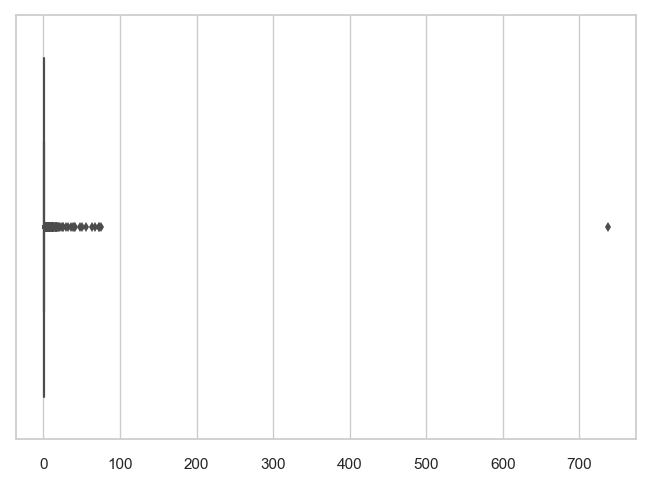

In [56]:
sns.boxplot(x=pd.DataFrame.from_dict(occ_hashtags, orient='index'))

In [57]:
def extract_hashtags(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)",i)
        hashtags.append(ht)
        
    return hashtags

In [58]:
hashtags_off = extract_hashtags(train["tweet"][train['subtask_a']=="OFF"])
hashtags_not = extract_hashtags(train["tweet"][train['subtask_a']=="NOT"])

In [59]:
hashtags_off = sum(hashtags_off,[])
hashtags_not = sum(hashtags_not,[])

In [60]:
hashtags_off = [hashtag.lower() for hashtag in hashtags_off]
hashtags_not = [hashtag.lower() for hashtag in hashtags_not]

In [69]:
occ_hashtags_off = Counter(hashtags_off)
occ_hashtags_not = Counter(hashtags_not)

In [72]:
pd.DataFrame.from_dict(occ_hashtags_off, orient='index')

,0
maga,242
trump2020,6
looneyleft,1
liberals,22
qproofs,1
trudeaumustgo,1
deepstatecorruption,1
putuporshutup,1
kavanaugh,21
callthevotealready,1


In [76]:
df_occ_hashtags_not = pd.DataFrame.from_dict(occ_hashtags_not, orient='index')

In [77]:
df_occ_hashtags_not[df_occ_hashtags_not[0]>1]

,0
maga,583
kag,60
china,3
tcot,46
kavanaugh,32
walkawaydemocrats2018,2
redwave,6
trumptrain,16
guncontrol,11
cdnpoli,16


In [81]:
df_occ_hashtags_off = pd.DataFrame.from_dict(occ_hashtags_off, orient='index')

In [85]:
df_occ_hashtags_off[df_occ_hashtags_off[0]>10]

,0
maga,242
liberals,22
kavanaugh,21
trump,15
qanon,20
confirmkavanaugh,13
tcot,11
conservatives,20
walkaway,27
kag,12


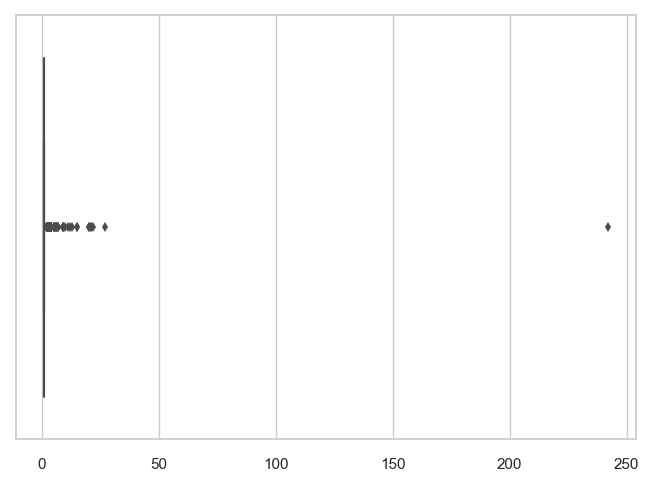

In [83]:
sns.boxplot(x=df_occ_hashtags_off)

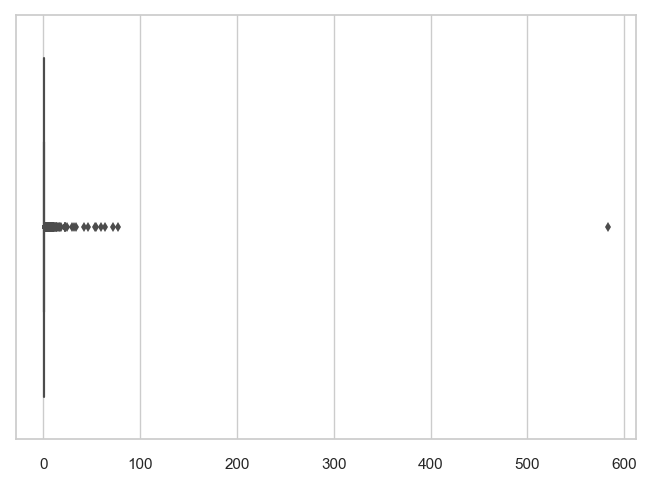

In [70]:
sns.boxplot(x=pd.DataFrame.from_dict(occ_hashtags_not, orient='index'))

In [61]:
def plot_hashtags(hashtags):
    freq = nltk.FreqDist(hashtags)
    df = pd.DataFrame({'Hashtag': list(freq.keys()),
                      'Count': list(freq.values())})
    df = df.nlargest(columns="Count", n = 10) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=df, x= "Hashtag", y = "Count")
    ax.set(ylabel = 'Count')
    plt.show()

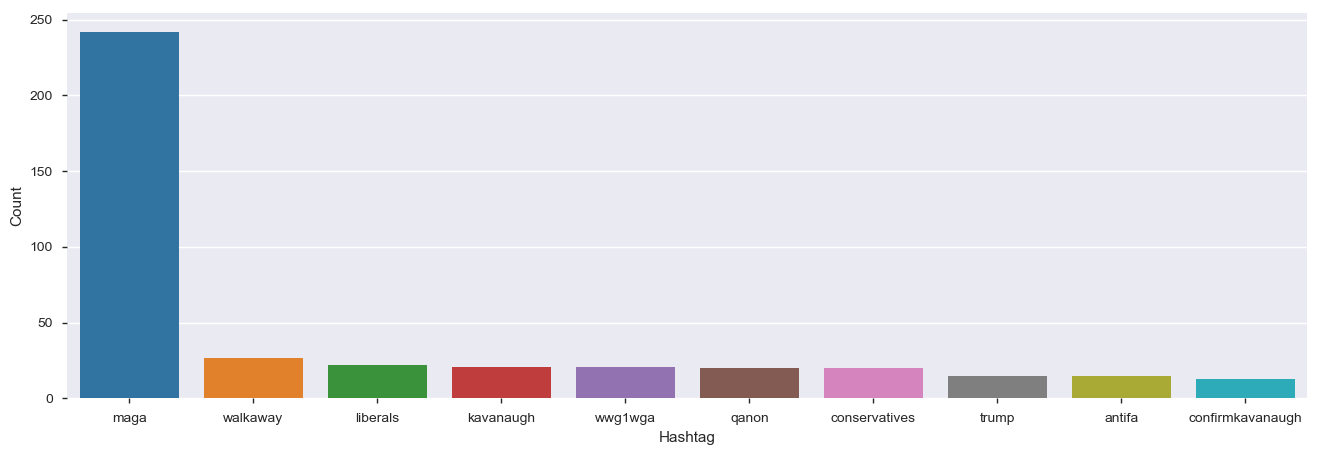

In [36]:
plot_hashtags(hashtags_off)

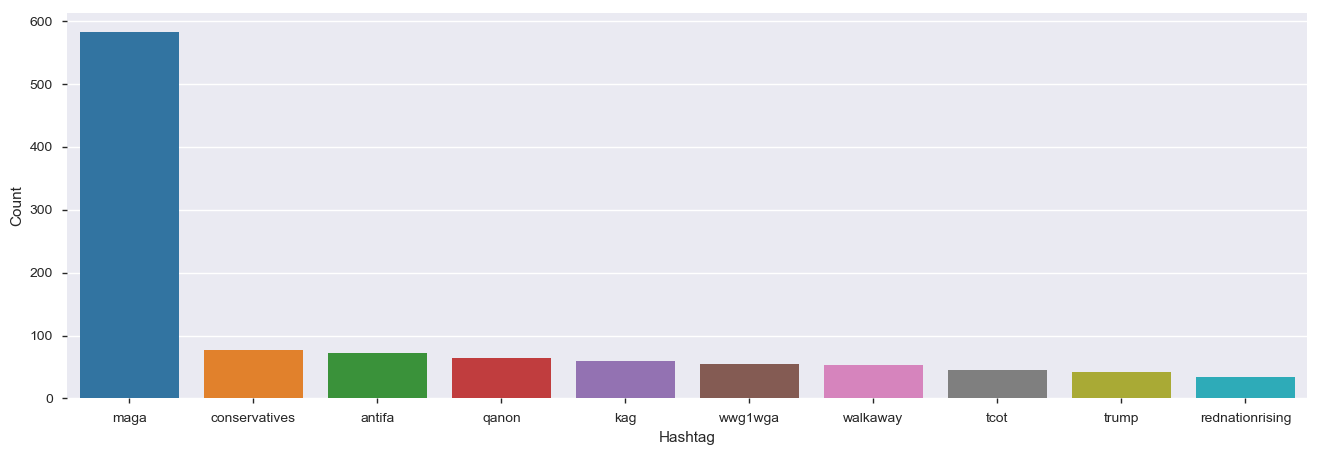

In [37]:
plot_hashtags(hashtags_not)

### Spelling correction

In [38]:
#https://pypi.org/project/pyspellchecker/
#https://github.com/phatpiglet/autocorrect
spell = SpellChecker()

misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for tweet in train['tweet'][1:10]:
    ex = clean(tweet)
    print(ex)
    ex = ex.split(" ")
    misspelled = spell.unknown(ex)
    print(misspelled)
    for word in misspelled:
        try:
            correction = spell.correction(word)
            print(correction)
        except:
            print("None")
            
#Probably don't use spellingcoorrection
#Corrections are not really good..

go home drunk maga trump
{'maga'}
mama
amazon investig chines employe sell intern data third parti seller look edg competit marketplac amazon maga kag china tcot
{'kag', 'competit', 'tcot', 'employe', 'investig', 'edg', 'maga', 'chines', 'marketplac'}
bag
compete
cot
employed
investing
edge
mama
chinese
marketplace
someon havetaken piec shit volcano
{'piec', 'someon', 'havetaken'}
piece
someone
havetaken
obama want liber illeg move red state
{'illeg', 'obama'}
killed
ibama
liber kookoo
{'kookoo'}
voodoo
oh noe tough shit
set()
liter talk lol mass shoot set up propaganda use divid us major issu gun control terror
{'issu', 'divid', 'liter'}
issue
david
later
buy icecream
set()
canada need anoth cuck alreadi enough looneyleft liber f king great countri qproof trudeaumustgo
{'countri', 'anoth', 'alreadi', 'looneyleft', 'qproof', 'cuck', 'trudeaumustgo'}
country
noth
already
looneyleft
proof
luck
trudeaumustgo


### Contractions

In [39]:
ex = train['tweet'][3]
print(ex)

new = contractions.fix(ex, slang=True)
print(new)

@USER Someone should'veTaken" this piece of shit to a volcano. 😂"
@USER Someone should haveTaken" this piece of shit to a volcano. 😂"


### Class Imbalance

Total comments: 13240
Fill NA with unknown
Train: 

NOT    0.667674
OFF    0.332326
Name: subtask_a, dtype: float64
NOT    8840
OFF    4400
Name: subtask_a, dtype: int64
Test: 

NOT    0.72093
OFF    0.27907
Name: subtask_a, dtype: float64
NOT    620
OFF    240
Name: subtask_a, dtype: int64


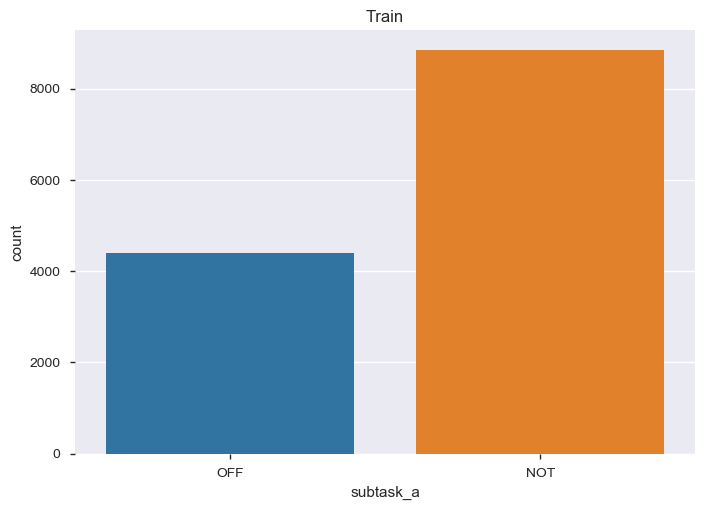

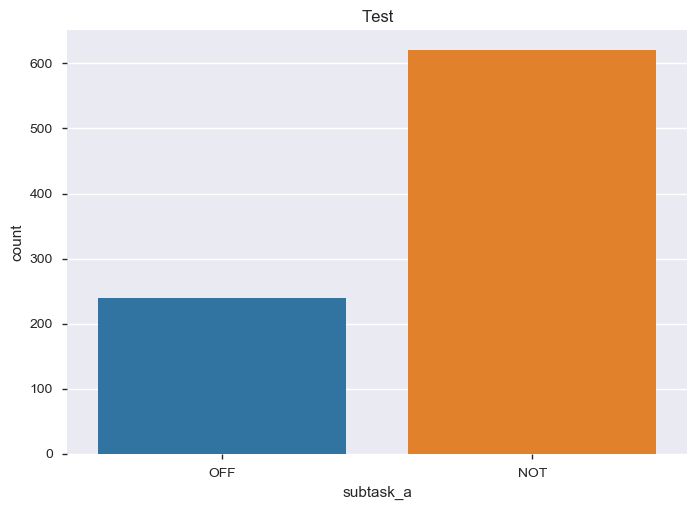

Train: 

UNKOWN    0.667674
TIN       0.292749
UNT       0.039577
Name: subtask_b, dtype: float64
UNKOWN    8840
TIN       3876
UNT        524
Name: subtask_b, dtype: int64
Test: 

TIN    0.8875
UNT    0.1125
Name: subtask_b, dtype: float64
TIN    213
UNT     27
Name: subtask_b, dtype: int64


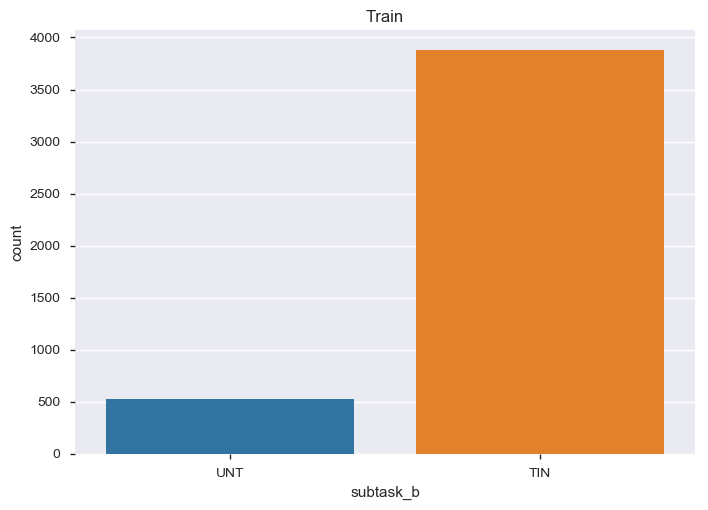

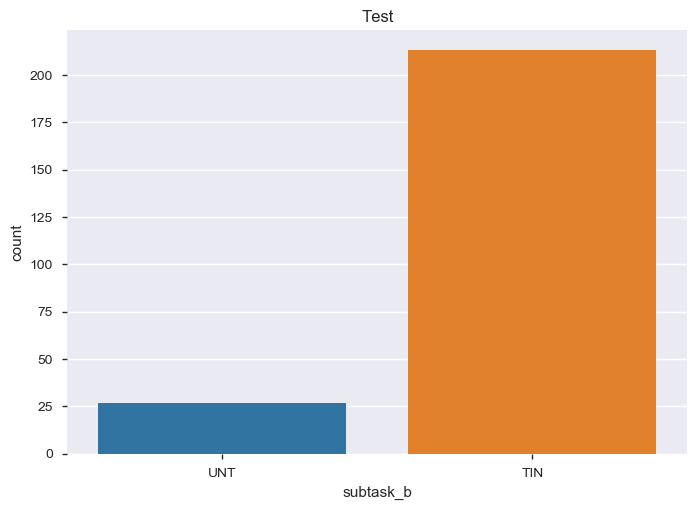

Train: 

UNKOWN    0.707251
IND       0.181798
GRP       0.081118
OTH       0.029834
Name: subtask_c, dtype: float64
UNKOWN    9364
IND       2407
GRP       1074
OTH        395
Name: subtask_c, dtype: int64
Test: 

IND    0.469484
GRP    0.366197
OTH    0.164319
Name: subtask_c, dtype: float64
IND    100
GRP     78
OTH     35
Name: subtask_c, dtype: int64


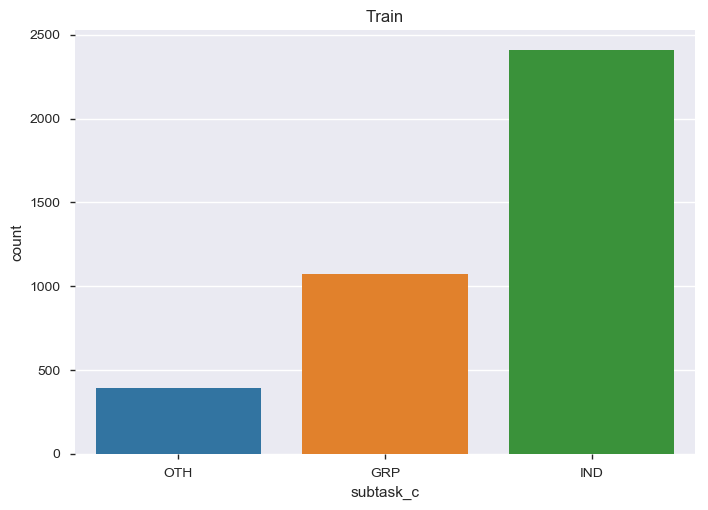

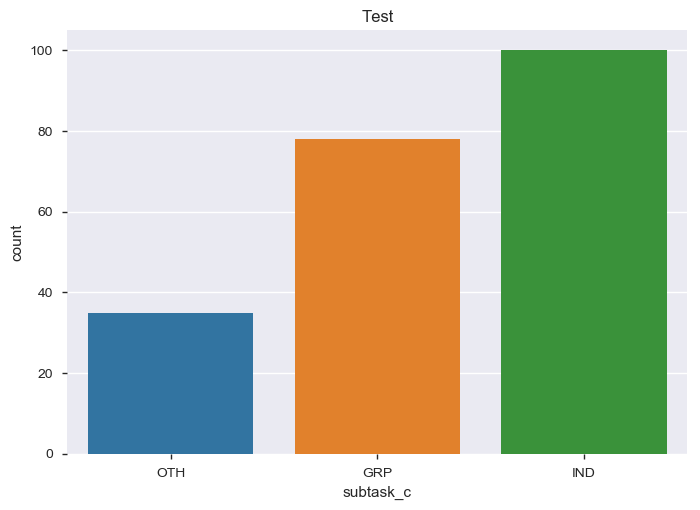

subtask_a  subtask_b  subtask_c
NOT        UNKOWN     UNKOWN       8840
OFF        TIN        GRP          1074
                      IND          2407
                      OTH           395
           UNT        UNKOWN        524
dtype: int64


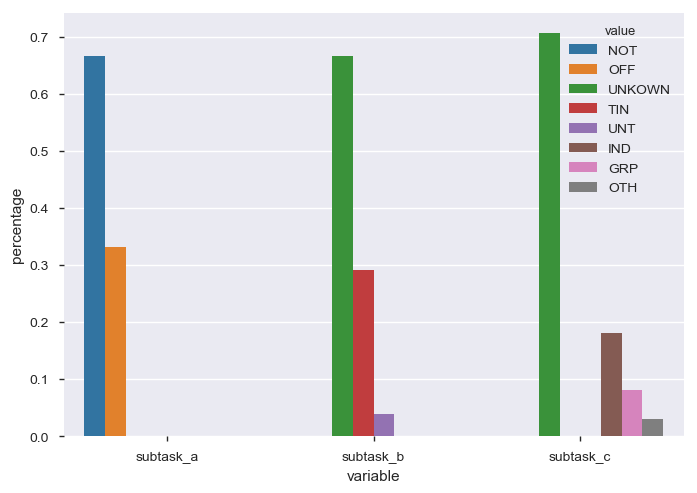

In [40]:
print("Total comments:", len(train))

missing_values = train.isnull().sum(); missing_values

print("Fill NA with unknown")
train = train.fillna("UNKOWN")
train.head(10)

def distribution(test, subtask, order):
    """
    Arguments:
        test: Test set A, B, C
        subtask: Subtask name (subtask_a, subtask_b, subtask_c)
        order: Order of the categories in the subtask (list)

    Output:
        Value percentages, count for the train and test set
        Countplots for the train and test set
    """
    print("Train: \n")
    print(train[subtask].value_counts(normalize=True))
    print(train[subtask].value_counts(normalize=False))

    print("Test: \n")
    print(test[subtask].value_counts(normalize=True))
    print(test[subtask].value_counts(normalize=False))

    sns.countplot(x=subtask, data=train, order=order)
    plt.title("Train")
    plt.show()

    sns.countplot(x=subtask, data=test, order=order)
    plt.title("Test")
    plt.show()

### Subtask A ####
distribution(test_a, 'subtask_a', ['OFF', 'NOT'])

# The are a lot more not offensive train than offensive train. The percentage is around 67% vs 33%.

### Subtask B ###
distribution(test_b, 'subtask_b', ['UNT','TIN'])
#UNT: Untargeted - A post containing non-targeted profanity and swearing
#TIN: Target Insult and Threats - A post containing an insult or threat to an individual, a group, or others

# The target group is large (88%) vs (12%) untargeted group.

### Subtask C ###
distribution(test_c, 'subtask_c', ['OTH','GRP','IND'])

#Ind. group is large

# The individual group is large in comparison to the other groups. There offensive train are more targeted to individuals.

### Subtasks ###
print(train.groupby(['subtask_a','subtask_b','subtask_c']).size())
train.head(1)
subtasks = pd.melt(train, id_vars=["id","tweet"], value_vars=['subtask_a','subtask_b','subtask_c'])
subtasks.head(5)

subtasks_normalize = subtasks.groupby(['variable'])['value'].value_counts(normalize=True).rename('percentage').reset_index()
subtasks_normalize

(ggplot() + geom_bar(aes(y= 'percentage' ,x = 'variable', fill = 'value'), data=subtasks_normalize, stat="identity"))
sns.barplot(x='variable', y='percentage', hue='value', data=subtasks_normalize)

### Wordclouds

In [ ]:
### Wordclouds ###
def generate_wordcloud(text):
    # Create stopwords
    stopwords = set(STOPWORDS)
    stopwords.add("USER")
    stopwords.add("URL")
    stopwords.add("amp")

    # Generate word cloud image
    wordcloud = WordCloud(stopwords=stopwords, max_words=300, background_color="black").generate(text)

    # Show image
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

text = " ".join(tweet for tweet in train["tweet"])
not_text = " ".join(tweet for tweet in train.loc[train["subtask_a"]=="NOT","tweet"])
off_text = " ".join(tweet for tweet in train.loc[train["subtask_a"]=="OFF","tweet"])
off_tin_unt_text = " ".join(tweet for tweet in train.loc[train["subtask_b"]=="UNT","tweet"])
off_tin_ind_text = " ".join(tweet for tweet in train.loc[train["subtask_c"]=="IND","tweet"])
off_tin_grp_text = " ".join(tweet for tweet in train.loc[train["subtask_c"]=="GRP","tweet"])
off_tin_oth = " ".join(tweet for tweet in train.loc[train["subtask_c"]=="OTH","tweet"])

generate_wordcloud(text)
generate_wordcloud(not_text)
generate_wordcloud(off_text)
generate_wordcloud(off_tin_unt_text)
generate_wordcloud(off_tin_ind_text)
generate_wordcloud(off_tin_grp_text)
generate_wordcloud(off_tin_oth)

In [114]:
import emojis
from nltk.stem.porter import *
stemmer = PorterStemmer()

def remove_emoji(tweet):
    tweet_emojis = emojis.get(tweet)

    not_emoji = []

    for token in tweet.split(" "):
        if token not in tweet_emojis:
            not_emoji.append(token)

    not_emoji = ' '.join(not_emoji)
    return(not_emoji)

In [250]:
def clean(tweet):

    #Remove emojis
    tweet = remove_emoji(tweet)

    #Remove mentions, usernames (@USER)
    tweet = re.sub("\s*@USER\s*", '', tweet)

    #Remove URL
    tweet = re.sub("URL", '', tweet)

    #And
    tweet = re.sub("&amp;", "and", tweet)
    tweet = re.sub("&", "and", tweet)

    #Lowercase
    tweet = tweet.lower()

    #Replace contractions and slang of word
    tweet = contractions.fix(tweet, slang=True)

    #Remove Hashtags + Words
    #tweet = re.sub("#\w+", '', tweet)

    #Remove Hashtag
    tweet = re.sub("#", '', tweet)

    #Remove punctuations, numbers and special characters (remove emoticons)
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)

    #Remove repeating characters (whitespace)
    tweet = re.sub("\s+"," ", tweet)

    #Tokenize tweet
    tt = TweetTokenizer(preserve_case=False,
                    strip_handles=True,
                    reduce_len=True)

    tweet_tokens = tt.tokenize(tweet)

    #Remove stopwords
    #stopwords = set(STOPWORDS)
    #tweet_tokens = [token for token in tweet_tokens if token not in stopwords]

    #Stemming
    #tweet_stem = [stemmer.stem(token) for token in tweet_tokens]

    clean = " ".join(tweet_tokens)
    return clean

def clean_tokenizer(tweet):

    #Remove mentions (@USER)
    tweet = re.sub("\s*@USER\s*", '', tweet)

    #Remove URL
    tweet = re.sub("URL", '', tweet)

    #Remove Hashtags + Words
    tweet = re.sub("#\w+", '', tweet)

    #Remove emojis
    tweet = remove_emoji(tweet)

    #Replace abbreviation of word
    tweet = contractions.fix(tweet, slang=True)

    #Rempve spaces
    tweet = re.sub("&amp", "", tweet)
    #Remove repeating characters (whitespace)
    tweet = re.sub("\s{2,}"," ", tweet)

    #Remove punctuations, numbers and special characters
    #Remove smileys (done by removing punctuation, nubmers and special characters)
    tweet = re.sub('[^a-zA-z]', ' ', tweet)

    #Tokenize tweet
    tt = TweetTokenizer(preserve_case=False,
                    strip_handles=True,
                    reduce_len=True)

    tweet_tokens = tt.tokenize(tweet)

    #Remove stopwords
    stopwords = set(STOPWORDS)
    tweet_tokens = [token.lower() for token in tweet_tokens if token not in stopwords]

    return tweet_tokens

import emoji
def clean_bert(tweet):
     
    #Remove emojis
    #print(emoji.demojize(tweet))
    tweet = re.sub(":[a-zA-Z\-\_]*:","", emoji.demojize(tweet)) #:hear-no-evil_monkey: 
    tweet = re.sub(":\w+:","", emoji.demojize(tweet))
    tweet = re.sub(":\w+\’\w+:","", emoji.demojize(tweet)) #:woman's_boot:

    #tweet = remove_emoji(tweet)

    #print(tweet)
    
    #Remove mentions, usernames (@USER)
    tweet = re.sub("\s*@USER\s*", '', tweet)
    #print(tweet)
    
    #Remove URL
    tweet = re.sub("\s*URL\s*", '', tweet)
    #print(tweet)
    
    #And
    tweet = re.sub("&amp;", "and", tweet)
    tweet = re.sub("&", "and", tweet)
    #print(tweet)
    
    #Replace contractions and slang of word
    tweet = re.sub("i'm", "I'm", tweet)
    tweet = contractions.fix(tweet, slang=True)
    #print(tweet)
    
    #tweet = re.sub('[^a-zA-z]', ' ', tweet)

    #Lowercase
    tweet = tweet.lower()
    #print(tweet)
    
    #Remove Hashtags + Words
    tweet = re.sub("#\s*\w+\s*", '', tweet)
    #print(tweet)
    
    #Remove Hashtag
    tweet = re.sub("\s*#\s*", '', tweet)

#     Remove punctuations, numbers and special characters (remove emoticons)
#    tweet = re.sub('[^a-zA-Z]', ' ', tweet)

    #Remove repeating characters (whitespace)
    tweet = re.sub("\s+"," ", tweet)
    #print(tweet)
    
    #Tokenize tweet
    tt = TweetTokenizer(preserve_case=False,
                    strip_handles=True,
                    reduce_len=True)

    tweet_tokens = tt.tokenize(tweet)

    #Remove stopwords
    # stopwords = set(STOPWORDS)
    # tweet_tokens = [token for token in tweet_tokens if token not in stopwords]
    #
    # #Stemming
    # tweet_stem = [stemmer.stem(token) for token in tweet_tokens]
    #
    clean = " ".join(tweet_tokens)
    return tweet

### Features

In [251]:
def remove_emoji(tweet):
    tweet_emojis = emojis.get(tweet)

    not_emoji = []

    for token in tweet.split(" "):
        if token not in tweet_emojis:
            not_emoji.append(token)

    not_emoji = ' '.join(not_emoji)
    return(not_emoji)

stopwords = set(STOPWORDS)

def generate_features(df):

    df["tmp_tweet"] = df["tweet"].copy()

    #URL
    df["count_mention"] = df["tmp_tweet"].apply(lambda x: len(re.findall("URL", str(x))))

    #Hastags
    df["count_hashtag"] = df["tmp_tweet"].apply(lambda x: len(re.findall("#", str(x))))

    #Mentions
    df["count_mention"] = df["tmp_tweet"].apply(lambda x: len(re.findall("USER", str(x))))

    #Emoticons
    df["count_emojis"] = df["tmp_tweet"].apply(lambda x: emojis.count(x))

    #Remove URLS, # and mentions
    #Remove mentions (@USER)
    df["tmp_tweet"] = df["tmp_tweet"].apply(lambda x: re.sub("@USER", ' ', str(x)))

    #Remove URL
    df["tmp_tweet"] = df["tmp_tweet"].apply(lambda x: re.sub("URL", ' ', str(x)))

    #Remove hashtag + following word(s)
    df["tmp_tweet"] = df["tmp_tweet"].apply(lambda x: re.sub("#\w+", ' ', str(x)))

    #Remove emojis
    df["tmp_tweet"] = df["tmp_tweet"].apply(lambda x: re.sub(":\w+:",' ',emojis.decode(x)))

    #Punctuation
    df["count_punctuations"] = df["tmp_tweet"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

    #Remove punctuation
    df["tmp_tweet"] = df["tmp_tweet"].apply(lambda x: re.sub("[^a-zA-z]", ' ', str(x)))

    #Upper case
    df["count_words_upper"] = df["tmp_tweet"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    #Title case
    df["count_words_title"] = df["tmp_tweet"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    #Stopwords
    df["count_stopwords"] = df["tmp_tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

    #Sentences
    df['count_sent'] = df["tmp_tweet"].apply(lambda x: len(re.findall("\n",str(x)))+1)

    #Words
    df['count_word'] = df["tmp_tweet"].apply(lambda x: len(str(x).split()))

    #Unique words
    df['count_unique_word'] = df["tmp_tweet"].apply(lambda x: len(set(str(x).split())))

    #Letters
    df['count_letters'] = df["tmp_tweet"].apply(lambda x: len(str(x)))

    return(df)